In [1]:
import numpy as np

m = np.arange(25)
m = m.reshape((5, 5))

m[1:] - m[0]

array([[ 5,  5,  5,  5,  5],
       [10, 10, 10, 10, 10],
       [15, 15, 15, 15, 15],
       [20, 20, 20, 20, 20]])

In [4]:
index = np.array([2, 0, 1])
fsim = np.array([10, 11, 12])
fsim = np.take(fsim, index, 0)
fsim

array([12, 10, 11])

In [4]:
sim = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
xbar = np.add.reduce(sim[:-1], 0) / 3
xbar

array([5, 7, 9])

In [57]:
import numpy as np
from numpy import asfarray
import time

time_start = time.time()


def minimize_neldermead(func, x0, maxiter=100, initial_simplex=None,
                        xatol=1e-4, fatol=1e-4, adaptive=False, bounds=None):
    """
    Args:
        bounds: Sequence of ``(min, max)`` pairs for each element in `x`. None
                is used to specify no bound.
    """

    x0 = asfarray(x0).flatten()

    # 设定反射 rho、扩展 gamma、收缩 psi、回退 sigma 系数
    # 系数可以为固定 / 自适应
    if adaptive:
        dim = float(len(x0))
        rho = 1
        gamma = 1 + 2/dim
        alpha = 0.75 - 1/(2*dim)
        sigma = 1 - 1/dim
    else:
        rho = 1
        gamma = 2
        alpha = 0.5
        sigma = 0.5

    # 设定解的上下界
    if bounds is not None:
        dim = len(x0)
        lower_bound = [bounds[i][0] for i in range(dim)]
        upper_bound = [bounds[i][1] for i in range(dim)]
    
    # 将初始解根据上下界进行截断
    if bounds is not None:
        x0 = np.clip(x0, lower_bound, upper_bound)

    # 设置初始单纯形
    # 如果未给定初始单纯形：在初始解x0的基础上在各个维度伸缩 nonzdelt = 0.05
    nonzdelt = 0.05
    zdelt = 0.00025
    if initial_simplex is None:
        N = len(x0)
        sim = np.empty((N + 1, N), dtype=x0.dtype)
        sim[0] = x0
        for k in range(N):
            y = np.array(x0, copy=True)
            if y[k] != 0:
                y[k] = (1 + nonzdelt) * y[k]
            else:
                y[k] = zdelt
            sim[k + 1] = y
    else:
        sim = np.asfarray(initial_simplex).copy()
        N = sim.shape[1]

    # 将初始单纯形根据上下界截断
    if bounds is not None:
        sim = np.clip(sim, lower_bound, upper_bound)

    one2np1 = list(range(1, N + 1))
    fsim = np.empty((N + 1,), float)

    for k in range(N + 1):
        fsim[k] = func(sim[k])

    # 根据func(x)值排序，sim[0,:]为最优值
    ind = np.argsort(fsim)
    fsim = np.take(fsim, ind, 0)
    sim = np.take(sim, ind, 0)

    iterations = 1

    while iterations < maxiter:

        # 当顶点距离最大值或者目标值最大值小于一定值时，结束迭代
        if (np.max(np.ravel(np.abs(sim[1:] - sim[0]))) <= xatol and
                np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
            break
        
        # 重心 := 平均值
        xbar = np.add.reduce(sim[:-1], 0) / N

        # 反射值
        xr = (1 + rho) * xbar - rho * sim[-1]
        if bounds is not None:
            xr = np.clip(xr, lower_bound, upper_bound)
        fxr = func(xr)

        # 控制是否回退
        doshrink = 0

        if fxr < fsim[0]:  # 如果反射点为最优点，计算扩展点
            # 扩展点
            xe = (1 + rho * gamma) * xbar - rho * gamma * sim[-1]
            # 截断
            if bounds is not None:
                xe = np.clip(xe, lower_bound, upper_bound)
            fxe = func(xe)

            if fxe < fxr:  # 如果扩展点优于反射点，将最差点替换为扩展点
                sim[-1] = xe
                fsim[-1] = fxe
            else:  # 如果扩展点不是最优点，将最差点替换为反射点
                sim[-1] = xr
                fsim[-1] = fxr
        else:  # fsim[0] <= fxr, 反射点不是最优点
            if fxr < fsim[-2]:  # 如果反射点不是最优点，但是优于第二差点，替换最差点为反射点
                sim[-1] = xr 
                fsim[-1] = fxr
            else:  # fxr >= fsim[-2]，反射点不是最优点，但是优于第二差点
                if fxr < fsim[-1]:  # 反射点优于最差点
                    # 收缩点
                    xc = (1 + alpha * rho) * xbar - alpha * rho * sim[-1]
                    if bounds is not None:
                        xc = np.clip(xc, lower_bound, upper_bound)
                    fxc = func(xc)

                    if fxc <= fxr: # 如果收缩点优于反射点
                        sim[-1] = xc 
                        fsim[-1] = fxc
                    else:
                        doshrink = 1
                else:  # 反射点差于最差点
                    # 内收缩点
                    xcc = (1 - alpha) * xbar + alpha * sim[-1]
                    if bounds is not None:
                        xcc = np.clip(xcc, lower_bound, upper_bound)
                    fxcc = func(xcc)

                    if fxcc < fsim[-1]:  # 如果内收缩点优于最差点，替代最差点
                        sim[-1] = xcc
                        fsim[-1] = fxcc
                    else:
                        doshrink = 1

                if doshrink:  # 回退
                    for j in one2np1:
                        sim[j] = sim[0] + sigma * (sim[j] - sim[0])
                        if bounds is not None:
                            sim[j] = np.clip(sim[j], lower_bound, upper_bound)
                        fsim[j] = func(sim[j])

        ind = np.argsort(fsim)
        sim = np.take(sim, ind, 0)
        fsim = np.take(fsim, ind, 0)
        iterations += 1

    x = sim[0]
    fval = np.min(fsim)

    return x, fval

def func(x):
    return 100.0 * (x[1] - x[0]**2)**2 + (1.0 - x[1])**2

x_0 = np.array([-1.2, 1.0])

res = minimize_neldermead(func, x_0)
    
time_end = time.time()  # 记录结束时间
time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
print(time_sum)

9.936472177505493


0.5
0.1
1.5
0.657414375
0.1
1.6474143749999999
0.8292982759973958
0.10000000000000003
1.7892982759973957
1.0150700584326053
0.09999999999999998
1.9250700584326053
1.214086905703011
0.09999999999999998
2.054086905703011
1.425638395648218
0.10000000000000009
2.175638395648218
1.6489393904172043
0.09999999999999998
2.2889393904172044
1.8831221785568735
0.09999999999999998
2.3931221785568733
2.1272277906775154
0.09999999999999998
2.4872277906775153
2.380196401779562
0.09999999999999998
2.5701964017795618
2.6408590857704777 2.640856724185053
2.3615854245484513e-06


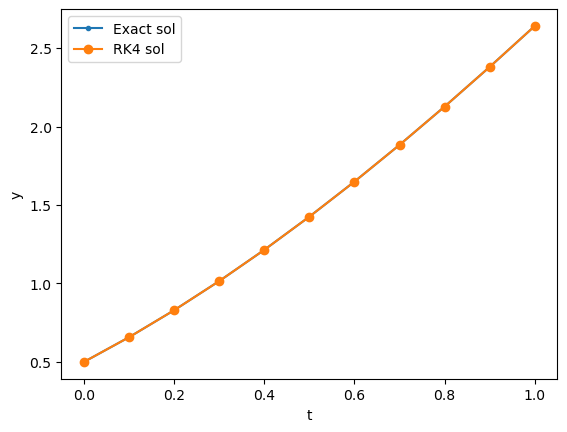

In [1]:
# Runge-Kutta method
import numpy as np
import matplotlib.pyplot as plt
 
class ode_sol:
    def __init__(self):
        self.y = None
        self.err = None
 
class my_ode_ivp:
    def __init__(self, fun, t_span, y0, t_eval=None, method='Euler'):
        self.N = 100    # if t_eval is none
        self.fun = fun
        self.t_span = t_span
        self.y0 = y0
        self.sol = ode_sol()
 
        if t_eval is None:
            self.t_eval = np.linspace(t_span[0], t_span[1], self.N)
        else:
            self.t_eval = t_eval
 
        self.sol.y = np.zeros(self.t_eval.shape[0])
        self.sol.y[0] = y0
 
        if method == 'Euler':
            self.euler()
        elif method == 'ModifiedEuler':
            self.modified_euler()
        elif method == 'ImprovedEuler':
            self.improved_euler()
        elif method == 'RK4':
            self.rk4()
        else:
            pass
 
    def euler(self):
        for i in range(1, self.t_eval.shape[0]):
            self.sol.y[i] = self.sol.y[i-1] + (self.t_eval[i]-self.t_eval[i-1])*self.fun(self.t_eval[i-1], self.sol.y[i-1])
     
    def modified_euler(self):
        for i in range(1, self.t_eval.shape[0]):
            h = self.t_eval[i]-self.t_eval[i-1]
            k1 = self.fun(self.t_eval[i-1], self.sol.y[i-1])
            self.sol.y[i] = self.sol.y[i-1] + h*self.fun(self.t_eval[i-1]+.5*h, self.sol.y[i-1]+.5*h*k1)
             
    def improved_euler(self):
        for i in range(1, self.t_eval.shape[0]):
            h = self.t_eval[i]-self.t_eval[i-1]
            k1 = self.fun(self.t_eval[i-1], self.sol.y[i-1])
            k2 = self.fun(self.t_eval[i-1]+h, self.sol.y[i-1]+h*k1)
            self.sol.y[i] = self.sol.y[i-1]+.5*h*(k1+k2)
 
    def rk4(self):
        for i in range(1, self.t_eval.shape[0]):
            h = self.t_eval[i]-self.t_eval[i-1]
            k1 = self.fun(self.t_eval[i-1], self.sol.y[i-1])
            k2 = self.fun(self.t_eval[i-1]+.5*h, self.sol.y[i-1]+.5*h*k1)
            print(self.sol.y[i-1])
            print(h)
            print(k1)
            k3 = self.fun(self.t_eval[i-1]+.5*h, self.sol.y[i-1]+.5*h*k2)
            k4 = self.fun(self.t_eval[i-1]+h, self.sol.y[i-1]+h*k3)
            self.sol.y[i] = self.sol.y[i-1]+h*(k1+2*k2+2*k3+k4)/6
 
 
# setting for ode: f(t,y), y0, t_span, t_eval
# two test examples: ex1, ex2
def f(t, y):
    return y-t**2+1 #ex1
    # return -t*y/(1-t*t) #ex2
 
# analytic solution
def yfun(t):
    return (t+1)**2 - .5*np.exp(t) #ex1
    # return np.sqrt(1-t*t) #ex2
 
y0 = .5 #ex1
# y0 = 1. #ex2
t_span = (0, 1.)
 
 
N = 11
t_eval = np.linspace(t_span[0], t_span[1], N)
 
# solve, compute error and plot
ode = my_ode_ivp(fun=f, t_span=t_span, y0=y0, t_eval=t_eval, method='RK4')
# 'RK4', 'Euler', 'ModifiedEuler', 'ImprovedEuler'
 
y_exact = yfun(ode.t_eval)
print(y_exact[-1], ode.sol.y[-1])
ode.sol.err = abs(ode.sol.y[-1]-y_exact[-1])
print(ode.sol.err)
 
plt.plot(ode.t_eval, y_exact,'.-', label='Exact sol')
plt.plot(ode.t_eval, ode.sol.y, 'o-', label='RK4 sol')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()

In [2]:
a = np.array([1, 2, 3, 4, 5])
b = np.array([1, 2, 3, 4, 5])
print(a*b)

[ 1  4  9 16 25]
